In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# leggo il dataset
X = np.genfromtxt("current_dataset_1701867955.txt", delimiter = ',')
Y = np.genfromtxt("current_target_1701867955.txt", delimiter = ',')

# treshold sulla varianza 
tokeep = np.arange(len(X.T))
tokeep = tokeep[X.var(axis = 0) > 1e-15]
X = X[:,tokeep]

# normalizzazione
X = (X - X.mean(axis = 0)) / (X.var(axis = 0))**.5
Y = (Y - Y.mean(axis = 0)) / (Y.var(axis = 0))**.5

print(tokeep)

[ 0  1  2  3  4  5  6  7  8 12 13 14 18]


In [11]:
significato = np.array([
"Total energy",
"Backbone Hbond",
"Sidechain Hbond",
"VdW contribution",
"Electrostatic interactions",
"Solvation Polar",
"Solvation Hydrophobic",
"energy penalitation due to VdW clashes",
"Entropy cost of fixing the side chain ",
"Entropy cost of fixing the main chain ",
"Sloop entropy (boh)",
"Mloop entropy (boh)",
"Cost of having a cis peptide bond",
"VanderWaals’ torsional clashes (intraresidue) ",
"Backbone-backbone VanderWaals. These are not considered in the total ",
"Electrostatic contribution of the helix dipole ",
"Contribution of water bridges",
"Contribution of disulfide bonds ",
"Electrostatic interaction between molecules in the precomplex ",
"Psrtial covalent bonds: Interactions with bound metals ",
"Contribution of ionisation energy ",
"Entropy cost of forming a complex "
])

In [48]:
print("Rimosse:")
for rimossa in (significato[[
        i not in tokeep
    for i in range(len(significato))
]]):
    print("\t%s" % rimossa)
print("Tenute")
for tenuta in significato[tokeep]:
    print("\t%s" % tenuta)

Rimosse:
	Entropy cost of fixing the main chain 
	Sloop entropy (boh)
	Mloop entropy (boh)
	Electrostatic contribution of the helix dipole 
	Contribution of water bridges
	Contribution of disulfide bonds 
	Psrtial covalent bonds: Interactions with bound metals 
	Contribution of ionisation energy 
	Entropy cost of forming a complex 
Tenute
	Total energy
	Backbone Hbond
	Sidechain Hbond
	VdW contribution
	Electrostatic interactions
	Solvation Polar
	Solvation Hydrophobic
	energy penalitation due to VdW clashes
	Entropy cost of fixing the side chain 
	Cost of having a cis peptide bond
	VanderWaals’ torsional clashes (intraresidue) 
	Backbone-backbone VanderWaals. These are not considered in the total 
	Electrostatic interaction between molecules in the precomplex 


# Correlation Matrix

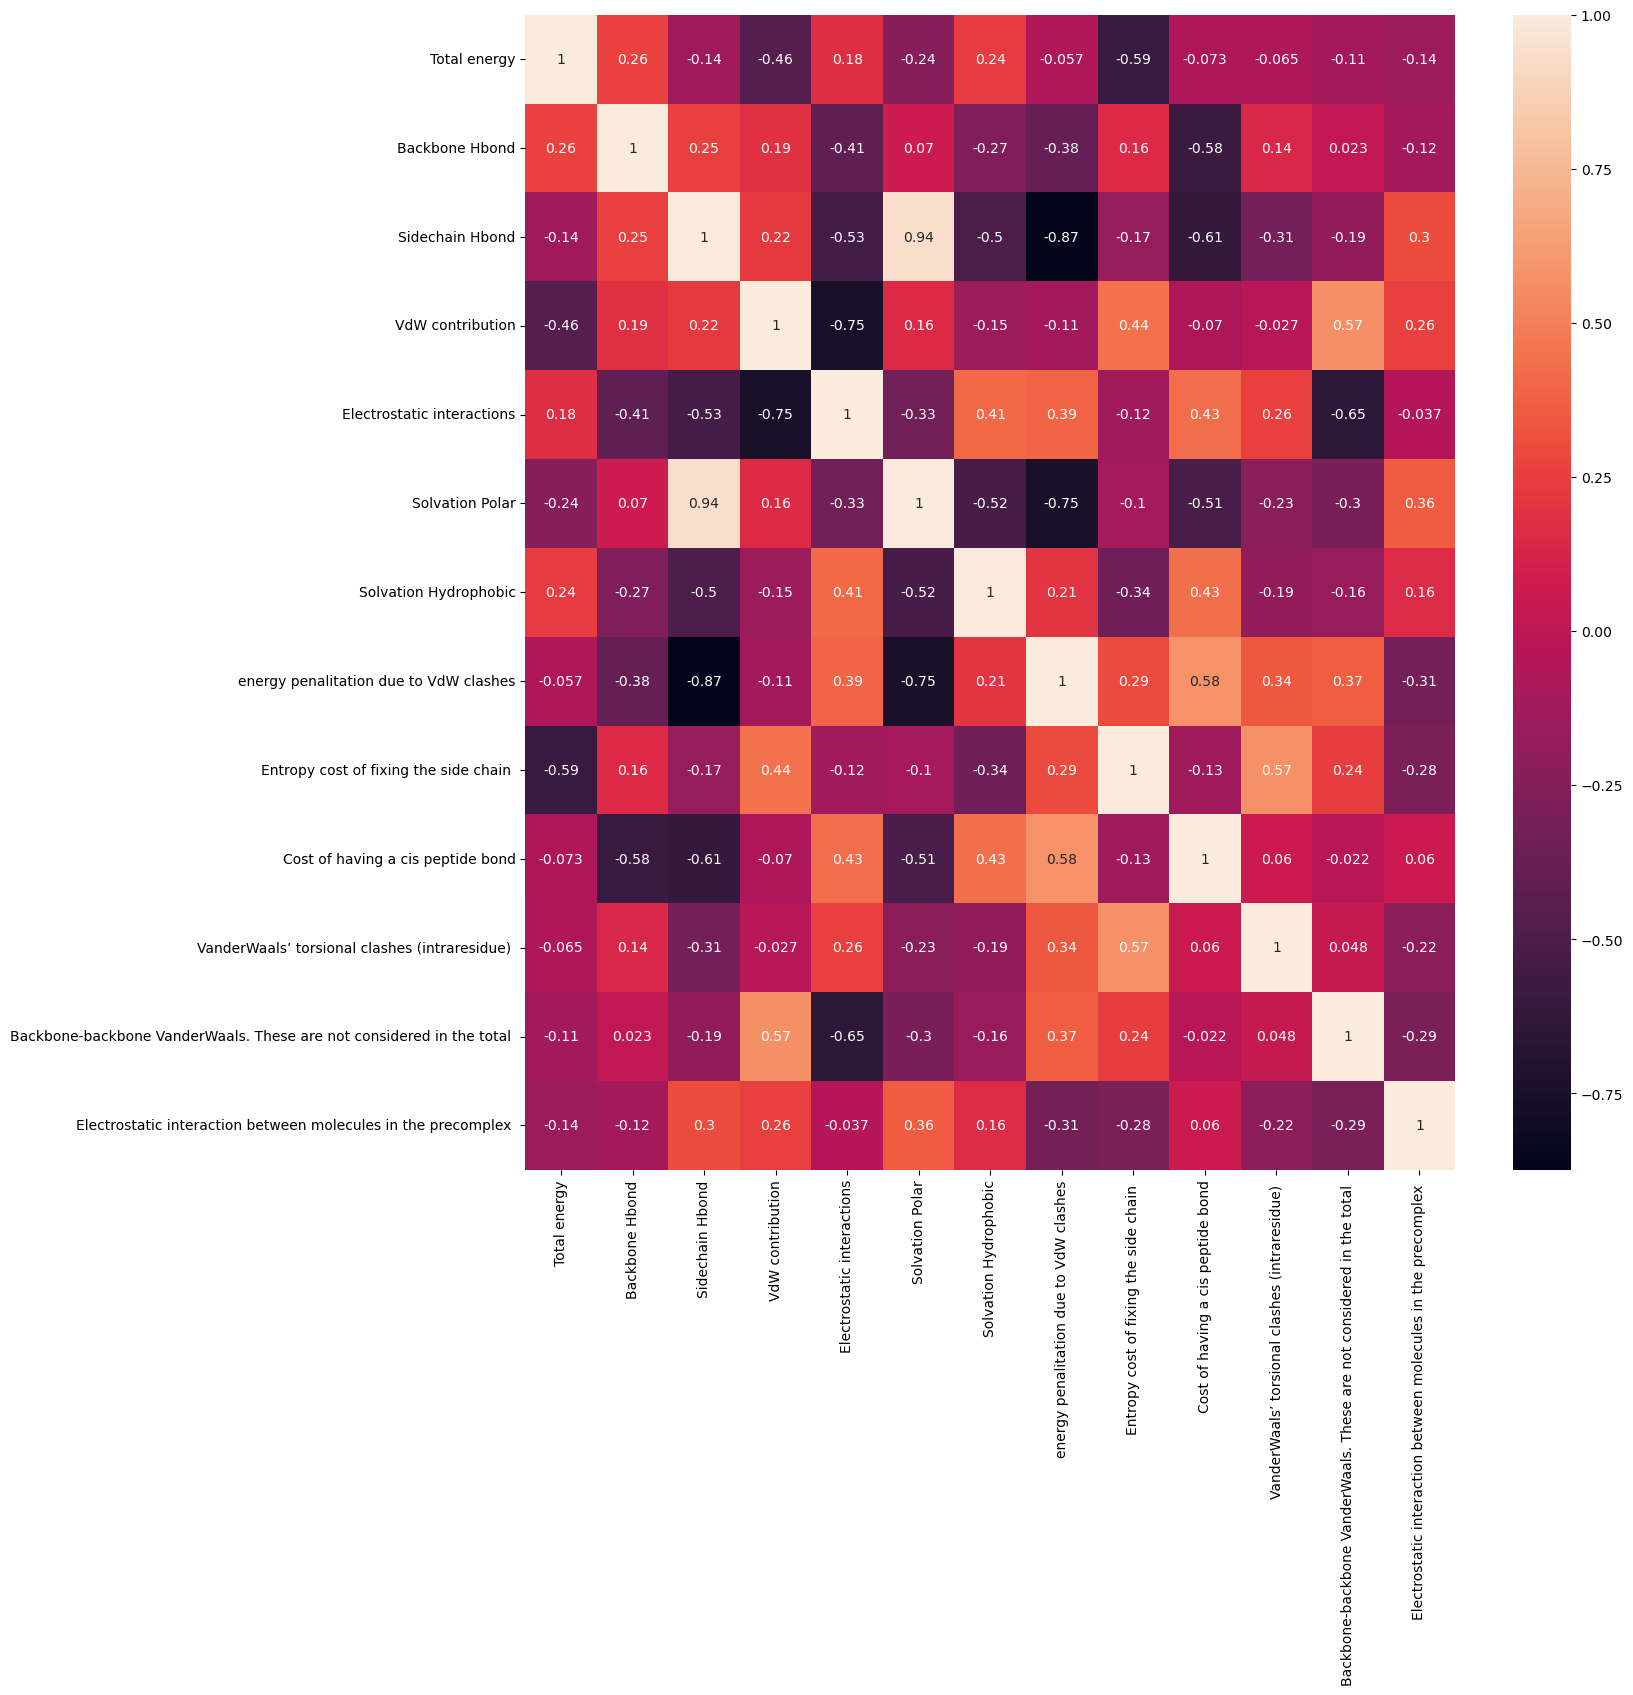

In [12]:
import seaborn as sns
C = np.corrcoef(X.T)
plt.figure(figsize = (15,15))
sns.heatmap(C, annot = True)
plt.xticks(np.arange(len(tokeep))+0.5,significato[tokeep],rotation= 90)
plt.yticks(np.arange(len(tokeep))+0.5,significato[tokeep],rotation= 0)
plt.show()

# Correlation with target variable

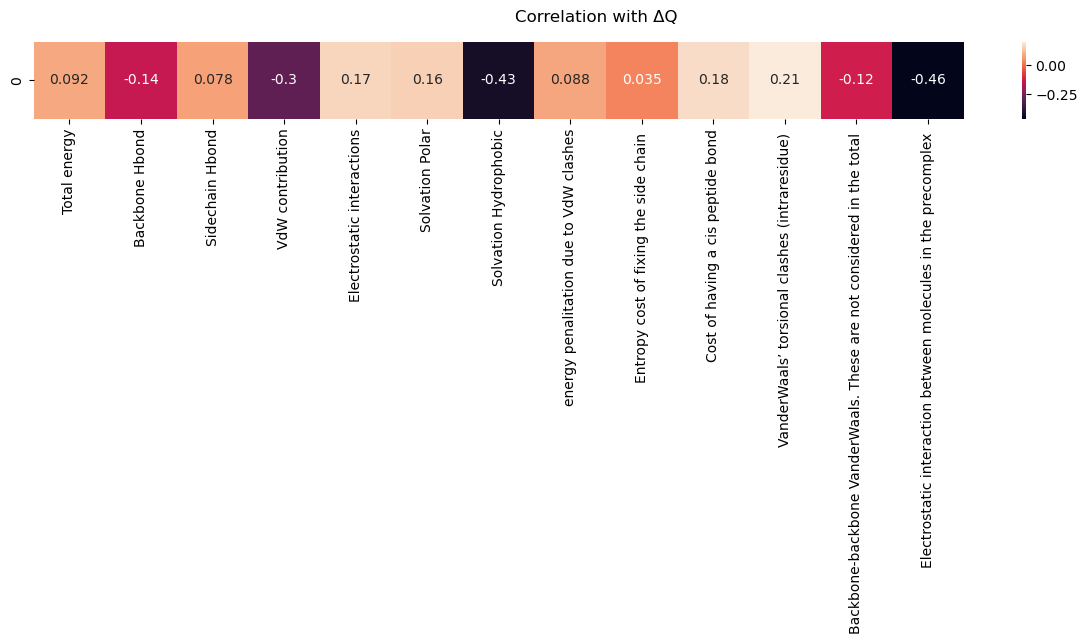

In [13]:
correlazioni_target = X.T @ Y / (np.linalg.norm(X,axis = 0) * np.linalg.norm(Y))
plt.figure(figsize = (15,1))
sns.heatmap(correlazioni_target[None,:], annot = True)
plt.suptitle("Correlation with ΔQ\n", y = 1.2)
plt.xticks(np.arange(len(tokeep))+0.5,significato[tokeep],rotation= 90)
plt.show()

# Pair plot

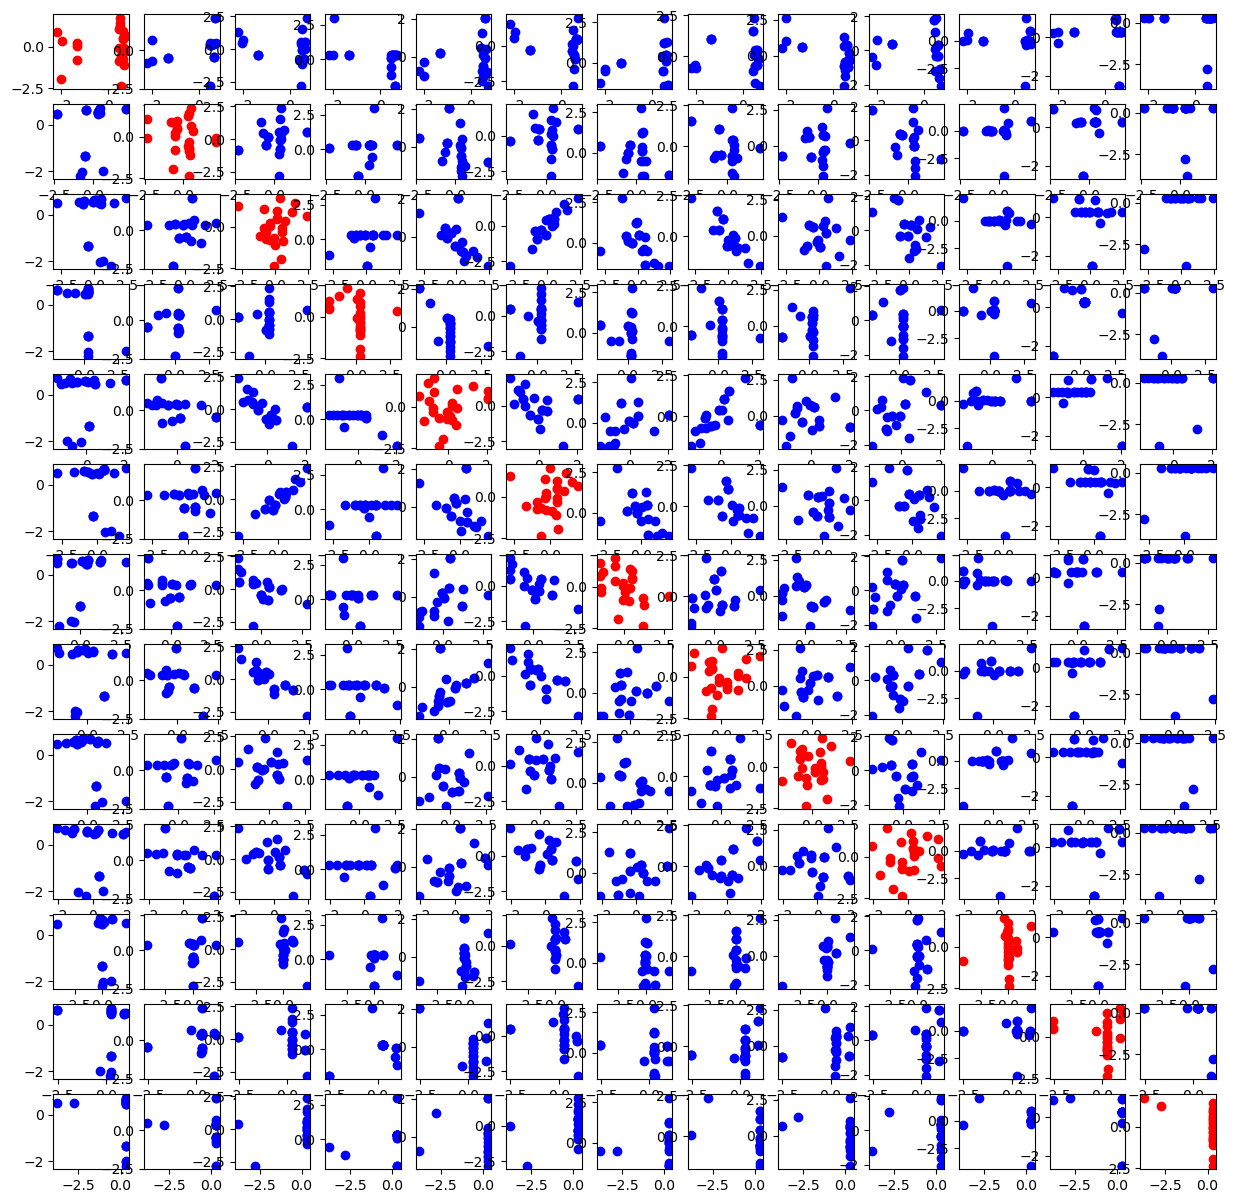

In [14]:
axs = plt.figure(figsize = (15,15)).subplots(nrows = len(X.T), ncols = len(X.T))
for i in range(len(axs)):
    for j in range(len(axs)):
        if i == j:
            axs[i,j].scatter(X[:,i],Y, color = 'red')
        else:
            axs[i,j].scatter(X[:,i],X[:,j], color = 'blue')            

# Optimization problem , correlation regressor

# $\text{Find } {\bf w } \text{ maximizes } corr({\bf y},X {\bf w}) = \frac{{\bf y}^TX{\bf w}}{\sqrt{{\bf y}^T{\bf y}{\bf w}^TX^TX{\bf w}}}$

In fact, it is like having a new feature ${\bf f}$  such tat<br>
# <center> $f_i := \sum_j X_{ij} w_j$ </center>
Defined in order to have maximal correlation with the q value

-0.5045506
0.8742035
0.8778676
0.88129556
0.88511467
0.888299
0.890092
0.8907176
0.8908719
0.8909222


<BarContainer object of 13 artists>

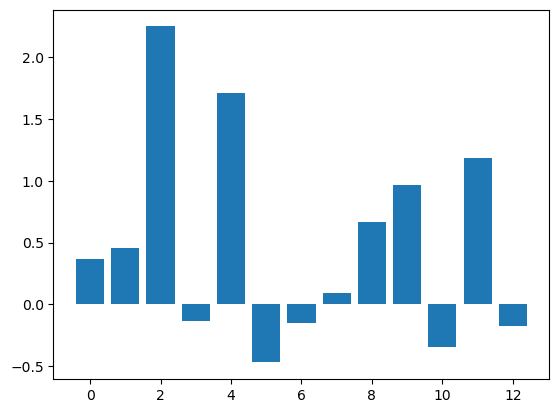

In [15]:
import jax
import jax.numpy as jnp

def reward(w,X,y):
    return y @ (X @ w) / jnp.sqrt( (y@y) * (w.T@X.T@X@w) )
reward = jax.jit(reward)
grad   = jax.grad(reward)


def corr_learn(X,Y, verbose = False):
    w = np.random.randn(X.shape[1])
    batch = 200
    lr    = 1e-1
    for i in range(batch * 10):
        new_w = w + lr * grad(w,X,Y)
        if reward(new_w,X,Y) > reward(w,X,Y):
            lr *= 1.1
            w   = new_w
        else:
            lr *= 0.9
        if verbose:
            if i % batch == 0:
                print(reward(w,X,Y))
    return w
w = corr_learn(X,Y,verbose = True)
plt.bar(np.arange(len(w)),w)

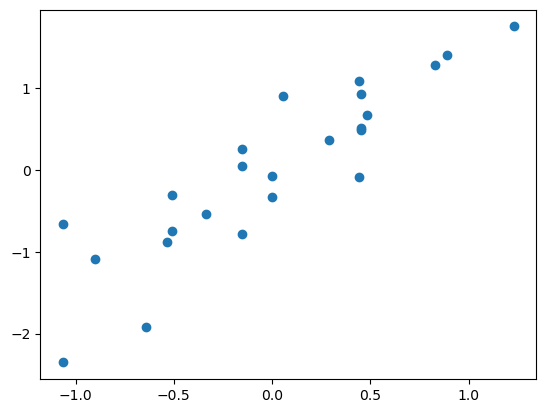

In [16]:
plt.scatter(X@w,Y)

<BarContainer object of 13 artists>

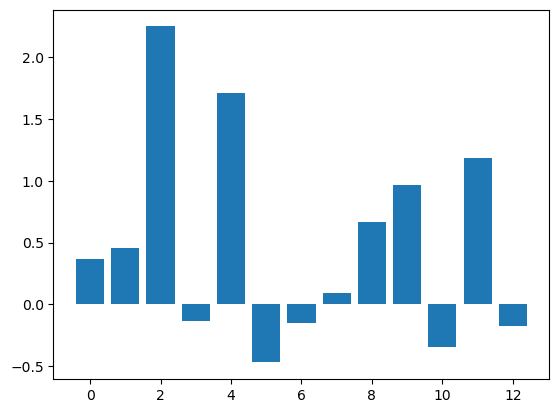

In [17]:
plt.bar( np.arange(len(w)), w)

# Leave one out bootstrap analysis of the regressor estimator

In [18]:
ws = []
phi = lambda X: np.c_[X]
predizioni = []
veri       = []
for i in range(len(X)):
    indici_train = np.arange(len(X)) != i
    indici_test  = ~indici_train
    X_train = phi(X)[indici_train]
    X_test  = phi(X)[indici_test]
    Y_train = Y[indici_train]
    Y_test  = Y[indici_test]
    
    w       = corr_learn(X_train,Y_train,verbose = False)
    ws.append(w)
    print("%.2f%%" % (float(i)/len(X) * 100))

0.00%
4.17%
8.33%
12.50%
16.67%
20.83%
25.00%
29.17%
33.33%
37.50%
41.67%
45.83%
50.00%
54.17%
58.33%
62.50%
66.67%
70.83%
75.00%
79.17%
83.33%
87.50%
91.67%
95.83%


(24,)


(array([2., 2., 3., 3., 5., 2., 3., 1., 2., 1.]),
 array([1.6870818, 1.8696383, 2.0521948, 2.2347512, 2.4173079, 2.5998645,
        2.7824209, 2.9649773, 3.147534 , 3.3300905, 3.512647 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

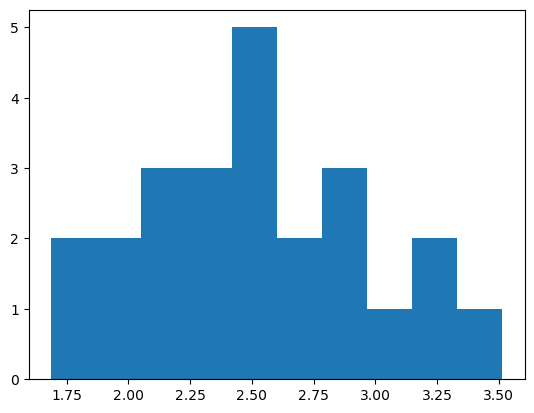

In [19]:
W = np.array(ws)
print(W[:,2].shape)
plt.hist( W[:,2] )

# Confidence interval on sensibility of target wrt features of the dataset

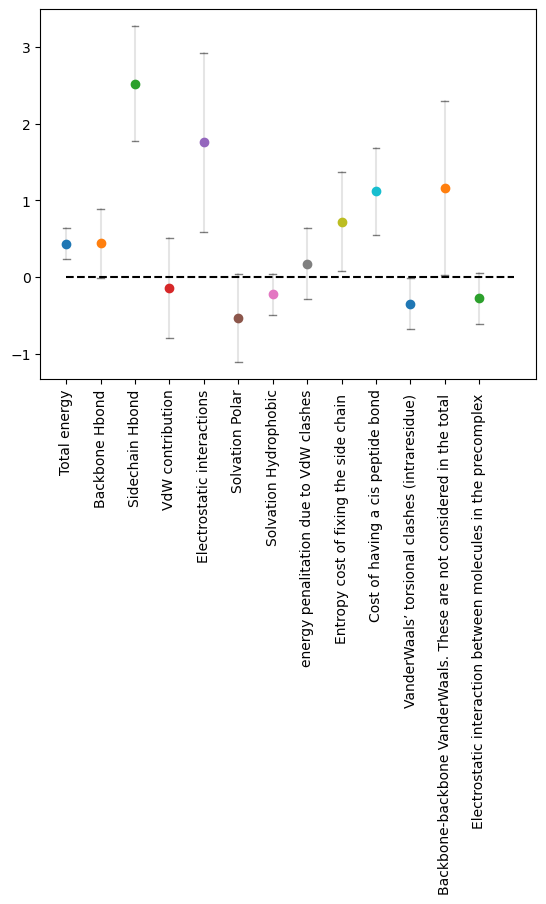

In [52]:
plt.xticks(np.arange(len(tokeep)),significato[tokeep],rotation= 90)
for i,w in enumerate(W.T):
    #plt.scatter(i , w.mean() + 2 * w.var()**.5,color = 'black', alpha = 1, s = 1)
    #plt.scatter(i , w.mean() - 2 * w.var()**.5,color = 'black', alpha = 1, s = 1)
    dev_stds = 1.645 # 90%
    t = np.linspace(w.mean() - dev_stds * w.var()**.5, w.mean() + dev_stds * w.var()**.5)
    plt.plot( i + t*0, t, alpha = 0.1, color = 'black')
    q = np.linspace(i - 0.1, i + 0.1)
    plt.plot( q , t[-1] + q * 0, alpha = 0.5, lw = 1., color = 'black')
    plt.plot( q , t[0 ] + q * 0, alpha = 0.5, lw = 1., color = 'black')
    plt.scatter(i , w.mean() , zorder = 99)

plt.plot(0 * np.arange(14), '--', color = 'black')

In [21]:
significato[tokeep]

array(['Total energy', 'Backbone Hbond', 'Sidechain Hbond',
       'VdW contribution', 'Electrostatic interactions',
       'Solvation Polar', 'Solvation Hydrophobic',
       'energy penalitation due to VdW clashes',
       'Entropy cost of fixing the side chain ',
       'Cost of having a cis peptide bond',
       'VanderWaals’ torsional clashes (intraresidue) ',
       'Backbone-backbone VanderWaals. These are not considered in the total ',
       'Electrostatic interaction between molecules in the precomplex '],
      dtype='<U69')

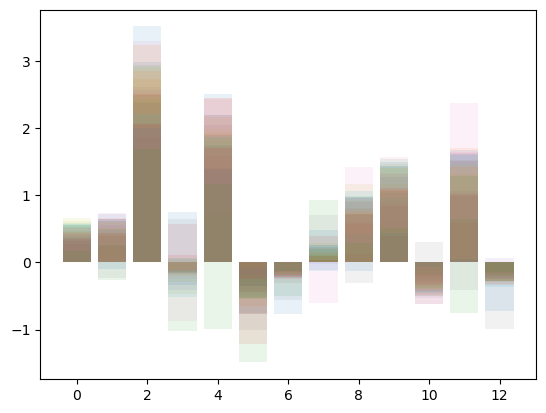

In [22]:
for w in W:
    plt.bar(np.arange(len(w)), w,alpha = 0.1)

In [8]:
X

array([[ 0.47860339,  0.31289985, -2.82540148, -1.20801652,  1.26874956,
        -2.82357249, -0.5224495 ,  2.36043474,  1.3068475 ,  1.10182926,
         2.13375874,  1.01486748, -2.78701082],
       [ 0.48048305,  0.4596177 ,  0.34886892, -0.62051364, -0.74255402,
         0.02069643, -0.55012343,  0.06621222,  0.67227036, -1.18724727,
        -0.34301485,  0.91385266, -3.77802754],
       [ 0.64783263,  0.42277583, -0.03837499,  0.27326502,  0.41098651,
         0.39779513,  1.26480266, -0.21827443, -0.32601932, -1.59236475,
        -0.02432056,  0.24607073,  0.29841083],
       [ 0.61736858, -0.41202399,  0.1166923 , -1.973073  ,  2.05306645,
         0.47321903,  0.47584575, -0.5436149 , -0.80938906,  0.3102378 ,
        -0.02147607, -2.5334382 ,  0.29841083],
       [-1.32994984, -0.52871927, -0.42783002,  0.27813957,  0.17562007,
        -0.2601638 , -0.04894279,  1.03533977,  0.61788001,  0.38084361,
        -0.0228152 ,  0.2597087 ,  0.29841083],
       [ 0.46597429,  0.344592